In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
rooth_path = 'data/'
deng_sj = pd.read_csv(rooth_path + 'deng_sj.csv')
deng_iq = pd.read_csv(rooth_path + 'deng_iq.csv')
test_sj = pd.read_csv(rooth_path + 'test_sj.csv')
test_iq = pd.read_csv(rooth_path + 'test_iq.csv')

In [26]:
dfs_train = [deng_sj, deng_iq]
dfs_test = [test_sj, test_iq]

In [27]:
# transform to feature week_start_date to datetime
def date_time(df):
    
    #setting a datetime index
    df.set_index('week_start_date', inplace=True)
    df.index = pd.to_datetime(df.index)
    
    return df

In [28]:
for df in dfs_train:
    df = date_time(df)

5.1473186737591e-09


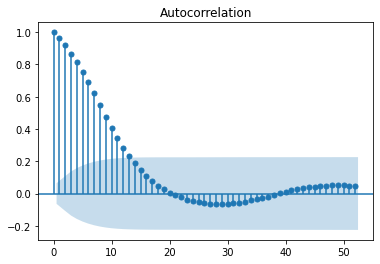

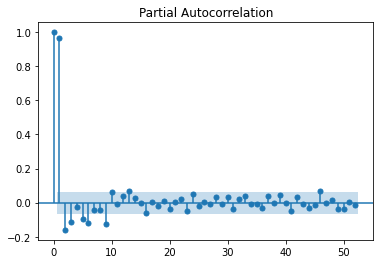

1.0672522948401663e-07


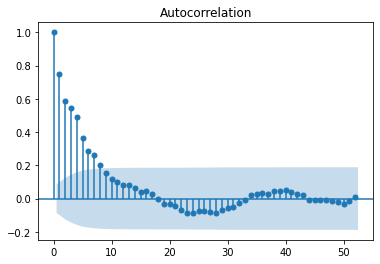

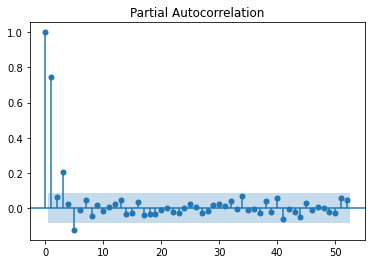

In [38]:
# Stationarity
for df in dfs_train:
    print(adfuller(df.total_cases)[1]) # p-value
    plot_acf(df.total_cases, lags=52)
    plot_pacf(df.total_cases, lags=52)
    plt.show()

We can see that the p-value is close to 0 -> indicates stationarity